# Dag layer cost visualization
In this notebook we will visualize the dags built from the different profiling schemes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
from schedule_simulator_core.DAGs import deserialize_dag
from schedule_simulator_core.utils import Mbps_to_Bpns

In [129]:
def plot_dag_overall_costs(dag, title=None, scaling_factors=None, figsize=(8,6)):
    costs = dict(forward_pass_units=0, backward_pass_units=0, communication_units=0)
    for layer in dag.topological_order:
        for cost in costs.keys():
            if scaling_factors is not None and cost in scaling_factors:
                m = scaling_factors[cost]
            else:
                m = 1
            costs[cost] += getattr(layer, cost) * m
    comp_to_comm_ratio = (costs["forward_pass_units"] + costs["backward_pass_units"]) / costs["communication_units"]
    data = list(zip(*costs.items()))
    f = None
    if figsize is not None:
        f = plt.figure(figsize=figsize)
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} {})".format(pct, absolute, time_unit)
    plt.pie(x=data[1], labels=data[0], autopct=lambda pct: func(pct, data[1]),
            textprops=dict(color="w", size=10))
    if title is not None:
        plt.title(title)
    plt.legend()
    if figsize is not None:
        plt.show()
    return f, comp_to_comm_ratio

In [144]:
def plot_dag_layer_wise_costs(dag, title=None, stacked=False, width=0.7, scaling_factors=None, figsize=(14,8)):
    N = len(dag.topological_order)
    xticks = list()
    costs = dict(forward_pass_units=list(), backward_pass_units=list(), communication_units=list())
    for layer in dag.topological_order:
        xticks.append(layer.extras["name"])
        for cost in costs.keys():
            if scaling_factors is not None and cost in scaling_factors:
                m = scaling_factors[cost]
            else:
                m = 1
            costs[cost].append(getattr(layer, cost) * m)

    f = None
    if figsize is not None:
        f = plt.figure(figsize=figsize)
    ind = np.arange(N)  # the x locations for the groups

    if stacked:
        accumulated_costs = np.zeros(shape=N)
        for cost in costs.keys():
            p = plt.bar(ind, costs[cost], width, bottom=accumulated_costs, label=cost)
            accumulated_costs += costs[cost]
    else:
        n = len(costs)
        for j, cost in enumerate(costs.keys()):
            p = plt.bar(ind - width / 2 + width / n * j, costs[cost], width / n, label=cost)
    plt.ylabel('Time per batch ({})'.format(time_unit))
    plt.xlabel("Layer name")
    if title is not None:
        plt.title(title)
    plt.xticks(ind, xticks, rotation="vertical")
    plt.legend()
    plt.axhline(0, color='black')
    plt.grid()
    if figsize is not None:
        plt.show()
    return f

In [145]:
def plot_dags(dags, title, scaling_factors):
    fig = plt.figure(figsize=(20,9*len(dags)))
    row = 0
    extreme_ylim = None
    layers_axs = list()
    for dag_name, dag in dags.items():
        dag_method = dag_name[dag_name.find("_")+1:][:-4]
        pie_ax = plt.subplot2grid(shape=(4,len(dags)), loc=(row, 0))
        _, rat = plot_dag_overall_costs(dag, title="Overall costs", scaling_factors=scaling_factors, figsize=None)
        layers_ax = plt.subplot2grid(shape=(4,len(dags)), loc=(row, 1), colspan=3)
        plot_dag_layer_wise_costs(dag, title="Layerwise costs", scaling_factors=scaling,figsize=None, stacked=True)
        ylim = plt.ylim()
        layers_axs.append(plt.gca())
        if extreme_ylim is None:
            extreme_ylim = ylim
        else:
            extreme_ylim = min(extreme_ylim[0], ylim[0]), max(extreme_ylim[1], ylim[1])
        pie_ax.annotate(dag_method, xy=(0, 0.5), xytext=(-pie_ax.yaxis.labelpad - 5, 0),
            xycoords=pie_ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center', rotation="vertical")
        pie_ax.annotate("comp_to_comm_ratio: {:.2f}".format(rat), xy=(0, 0.5), xytext=(-pie_ax.yaxis.labelpad + 15, 0),
            xycoords=pie_ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center', rotation="vertical")
        row += 1
    for ax in layers_axs:
        ax.set_ylim(extreme_ylim)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    fig.suptitle(title, size=30)
    fig.tight_layout()
    plt.show()
    return fig

In [146]:
network_rate = 10
network_unit = "Gbps"
Bpns_network_rate = Mbps_to_Bpns(network_rate)*1e3
time_mult = 1e-6
time_unit = "ms"
scaling = dict(communication_units=1/Bpns_network_rate*time_mult, forward_pass_units=time_mult, 
              backward_pass_units=time_mult)

## VGG16

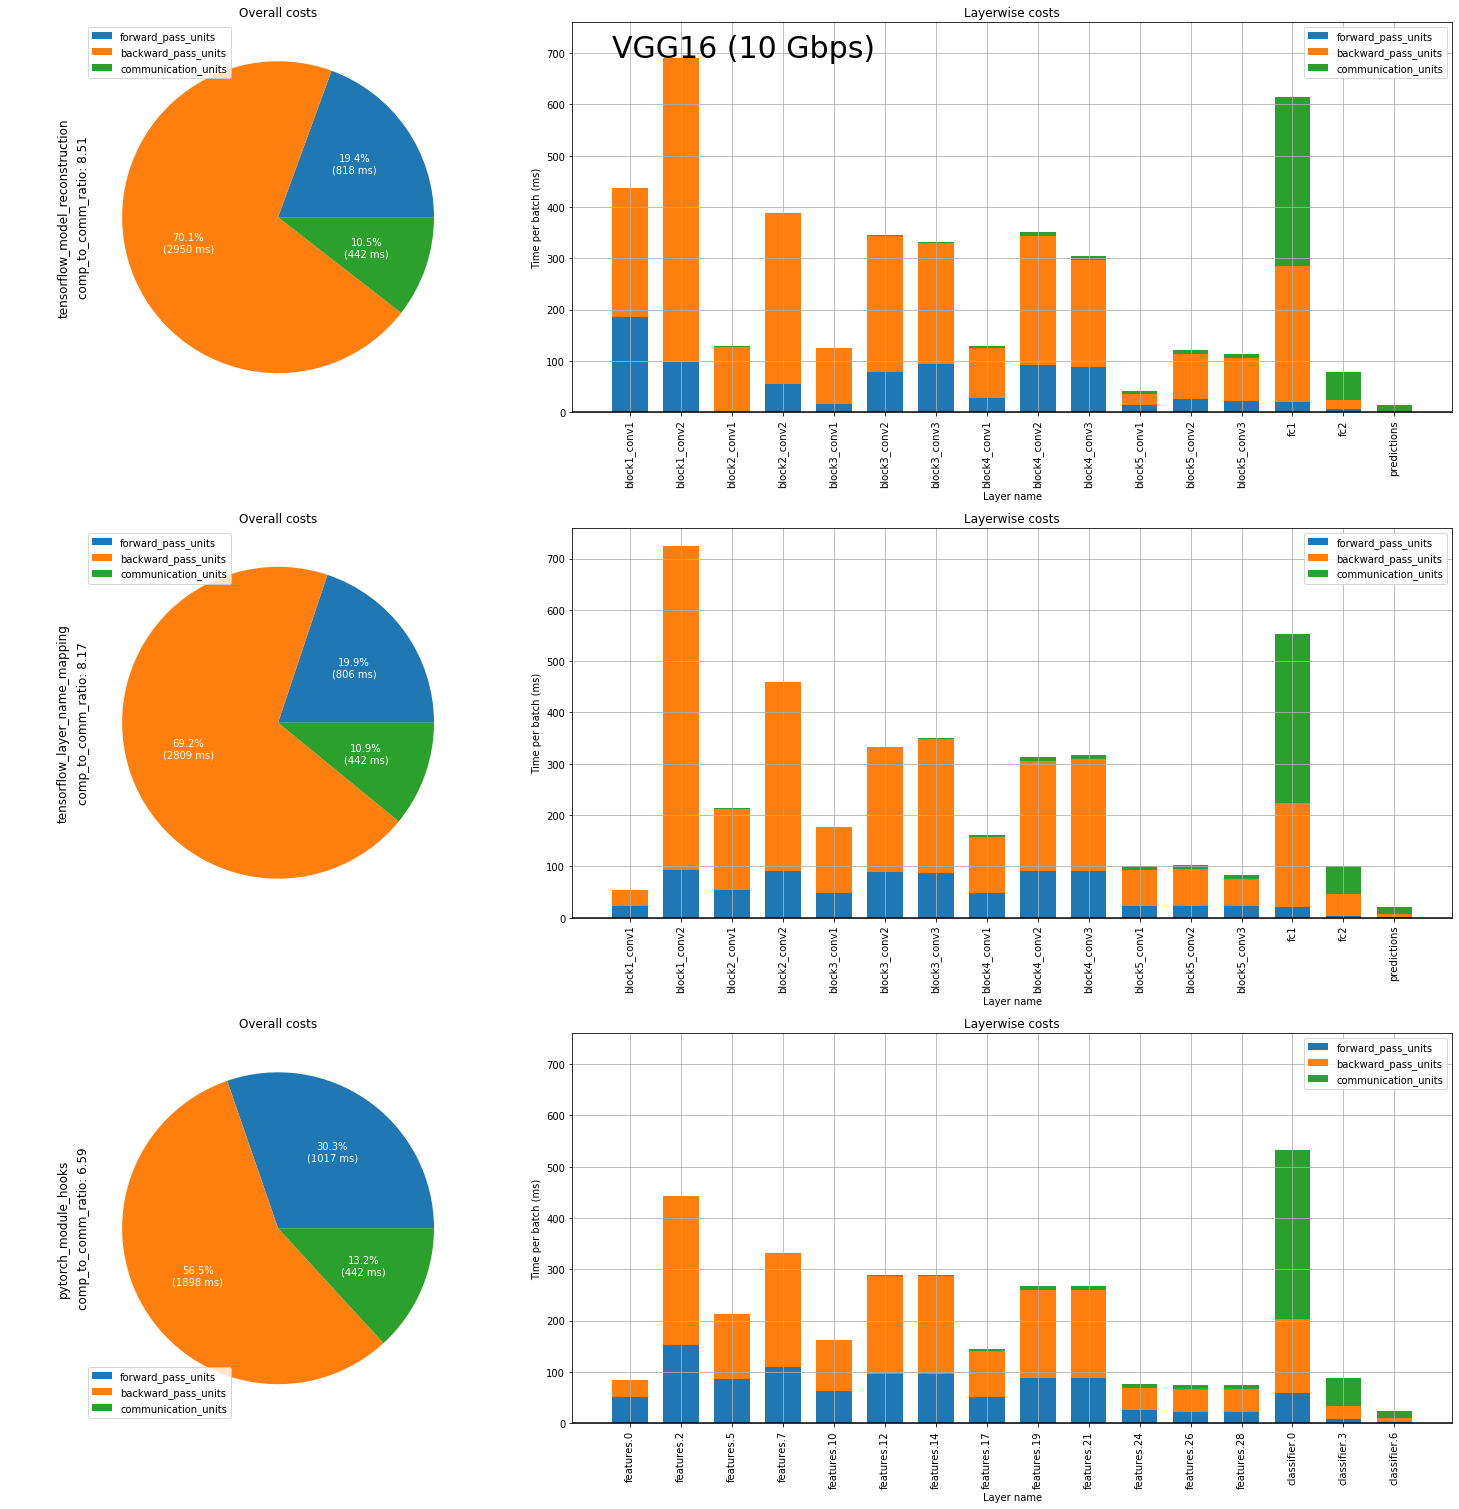

In [147]:
dag_name = "VGG16"
file_names = ["VGG16_tensorflow_model_reconstruction.dag", "VGG16_tensorflow_layer_name_mapping.dag",
              "vgg16_pytorch_module_hooks.dag"]
dags = dict()
for file_name in file_names:
    with open("../model_extraction/dags/{}".format(file_name)) as file:
        dag = deserialize_dag(file.read())
        dags[file_name] = dag
title = "{} ({} {})".format(dag_name, network_rate, network_unit)
f = plot_dags(dags, title, scaling_factors=scaling)
f.savefig("{}_dag_visualization.pdf".format(dag_name))